In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

RANDOM_STATE = 42

### Data importation

In [2]:
data = pd.read_csv('../data/bodyPerformance.csv')
data.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Data preparation

In [3]:
# renames columns
new_col_names = ['age', 'gender', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit_and_bend_forward_cm', 'sit_ups_counts',
       'broad_jump_cm', 'class']
data.columns = new_col_names

In [4]:
# split data into train validation and test
df_full_train, df_test = train_test_split(data, train_size=.8, random_state = RANDOM_STATE)
df_full_train.shape, df_test.shape

((10714, 12), (2679, 12))

In [5]:
df_full_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

### Data preprocessing

In [6]:
# check NA values
df_full_train.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body_fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit_and_bend_forward_cm    0
sit_ups_counts             0
broad_jump_cm              0
class                      0
dtype: int64

In [7]:
# drop duplicated rows
df_full_train.drop_duplicates(inplace = True)

In [8]:
# check data type
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10713 entries, 0 to 10713
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      10713 non-null  float64
 1   gender                   10713 non-null  object 
 2   height_cm                10713 non-null  float64
 3   weight_kg                10713 non-null  float64
 4   body_fat_%               10713 non-null  float64
 5   diastolic                10713 non-null  float64
 6   systolic                 10713 non-null  float64
 7   gripForce                10713 non-null  float64
 8   sit_and_bend_forward_cm  10713 non-null  float64
 9   sit_ups_counts           10713 non-null  float64
 10  broad_jump_cm            10713 non-null  float64
 11  class                    10713 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.1+ MB


### EDA

##### Numerical features

In [9]:
numerical_features = df_full_train.select_dtypes(include = ['float']).columns.tolist()

###### Statistics Summary

In [10]:
df_full_train[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10713.0,36.855129,13.649564,21.0,25.00000,32.0,48.0,64.0
height_cm,10713.0,168.511883,8.457068,139.5,162.30000,169.1,174.7,192.0
weight_kg,10713.0,67.409394,11.914442,26.3,58.20000,67.4,75.3,138.1
body_fat_%,10713.0,23.266266,7.274963,3.0,18.04355,22.8,28.1,78.4
diastolic,10713.0,78.733791,10.694640,6.0,71.00000,79.0,86.0,156.2
systolic,10713.0,130.247260,14.700118,14.0,120.00000,130.0,141.0,195.0
gripForce,10713.0,36.888323,10.609572,0.0,27.40000,37.8,45.1,70.5
sit_and_bend_forward_cm,10713.0,15.222707,8.378547,-25.0,10.90000,16.2,20.8,213.0
sit_ups_counts,10713.0,39.724447,14.235785,0.0,30.00000,41.0,50.0,78.0
broad_jump_cm,10713.0,189.993289,39.802149,0.0,162.00000,193.0,221.0,303.0


###### Univariate analysis

age
Skew : 0.59


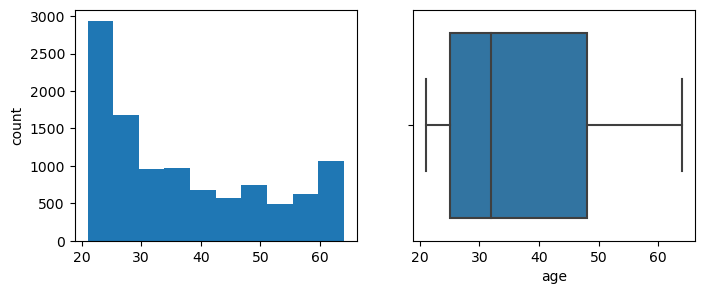

height_cm
Skew : -0.17


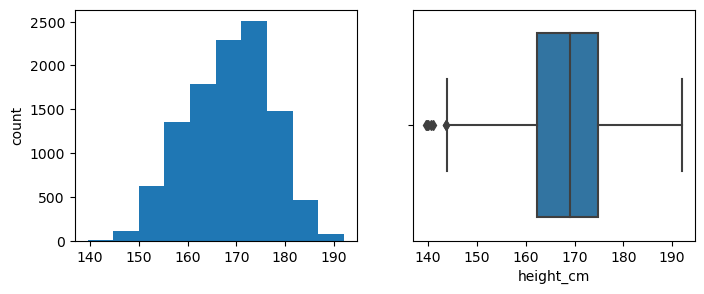

weight_kg
Skew : 0.35


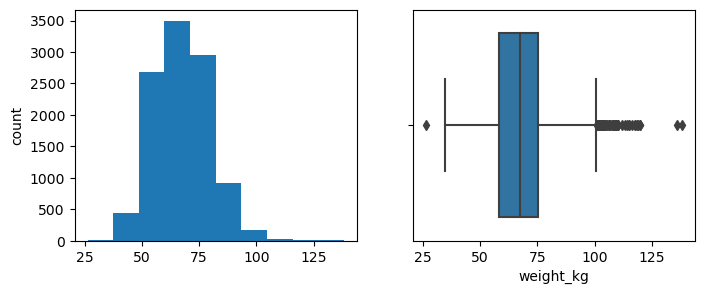

body_fat_%
Skew : 0.37


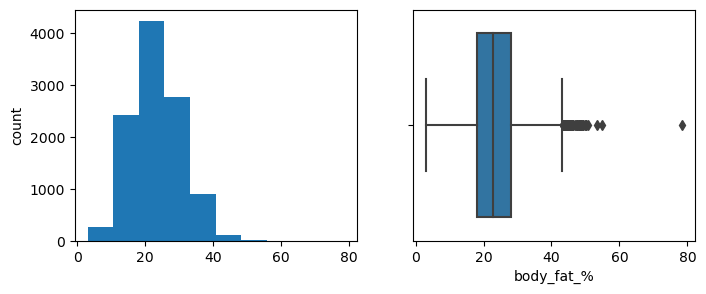

diastolic
Skew : -0.13


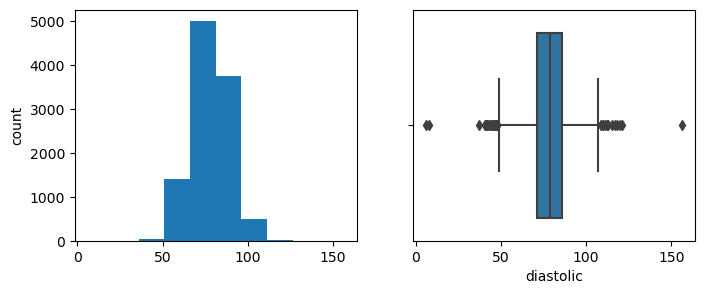

systolic
Skew : -0.03


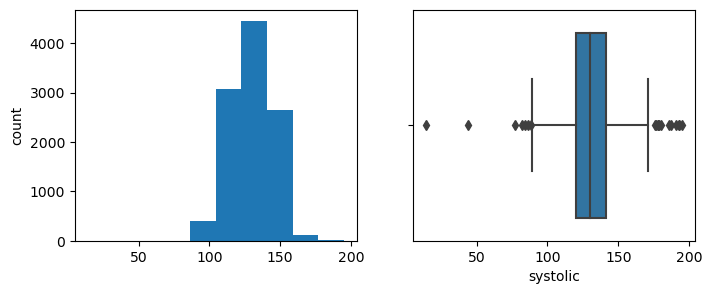

gripForce
Skew : 0.02


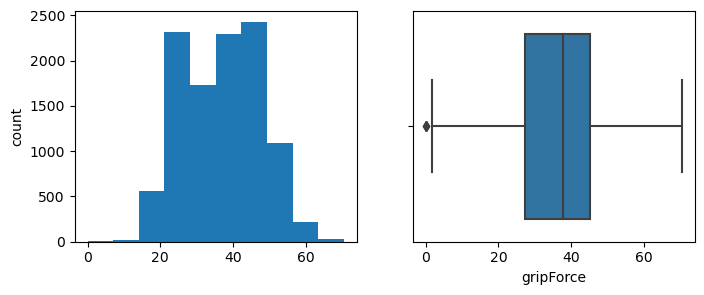

sit_and_bend_forward_cm
Skew : 0.42


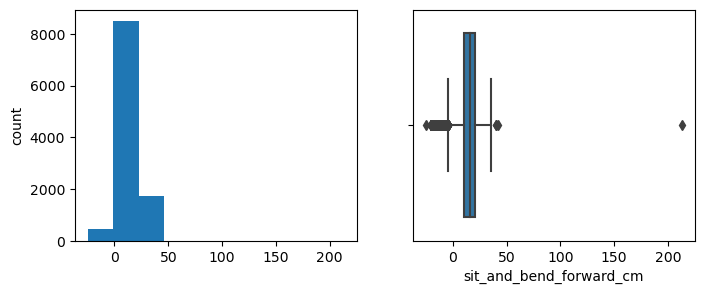

sit_ups_counts
Skew : -0.46


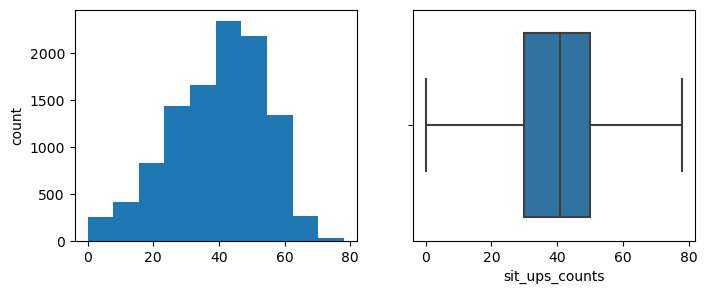

broad_jump_cm
Skew : -0.4


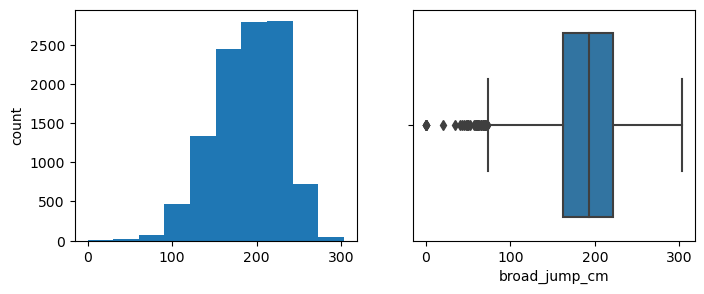

In [11]:
for col in numerical_features:
    print(col)
    print('Skew :', round(df_full_train[col].skew(), 2))
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    df_full_train[col].hist(grid=False, )
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_full_train[col], )
    plt.show()

###### Outliers analysis

In [12]:
for col in numerical_features:
    # Compute Q99
    Q99 = df_full_train[col].quantile(0.99)
    
    # Compute the mode
    mode_value = df_full_train[col].mode()[0]
    
    # Replace outliers with the mode
    df_full_train[col] = df_full_train[col].apply(lambda x: mode_value if x > Q99 else x)

###### Bivariate analysis

In [13]:
df_full_train.groupby(['class']).age.count()

class
A    2662
B    2685
C    2699
D    2667
Name: age, dtype: int64

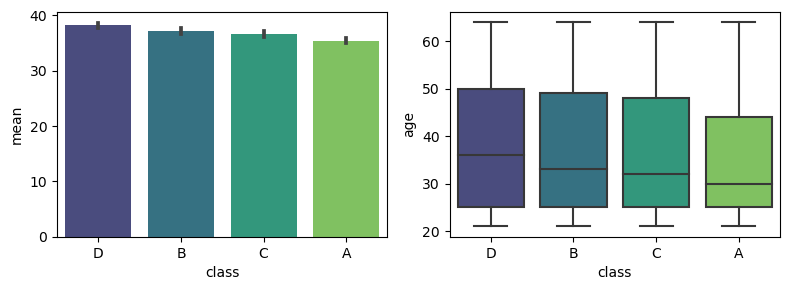

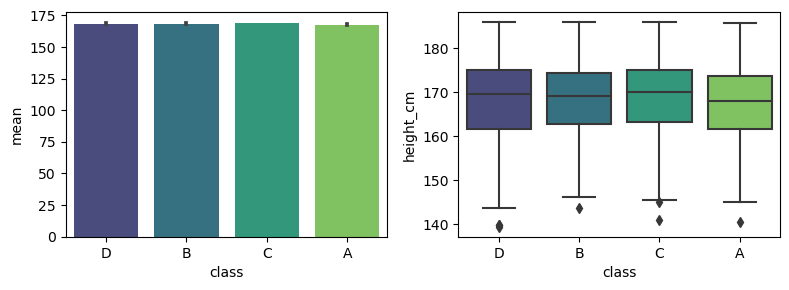

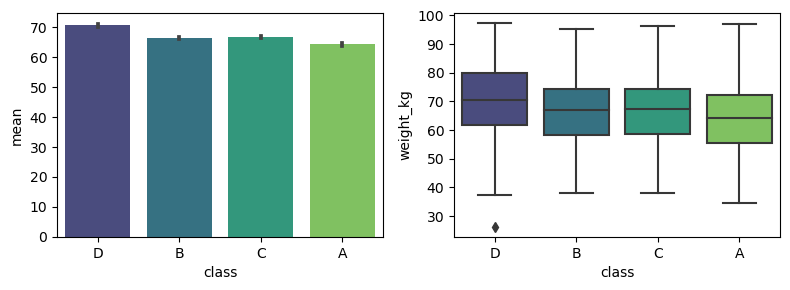

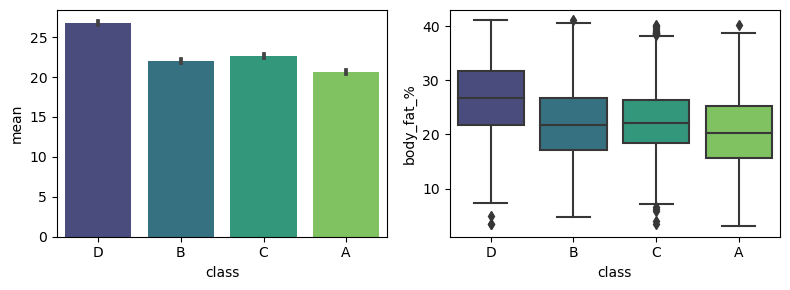

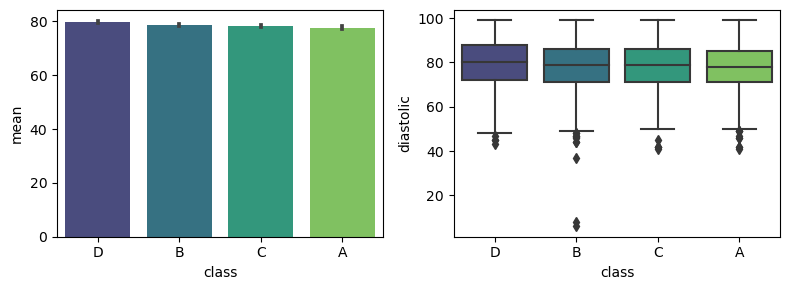

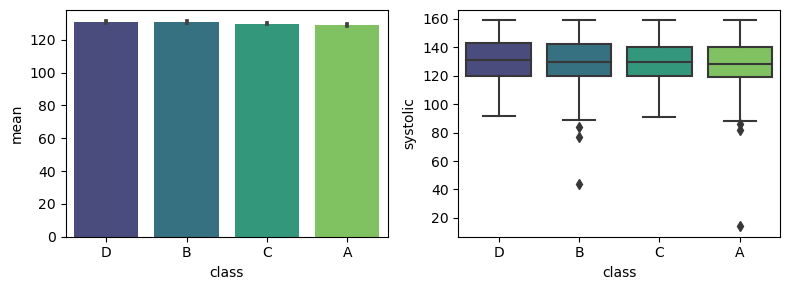

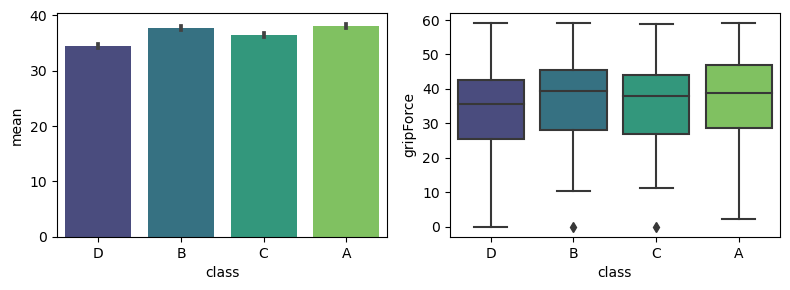

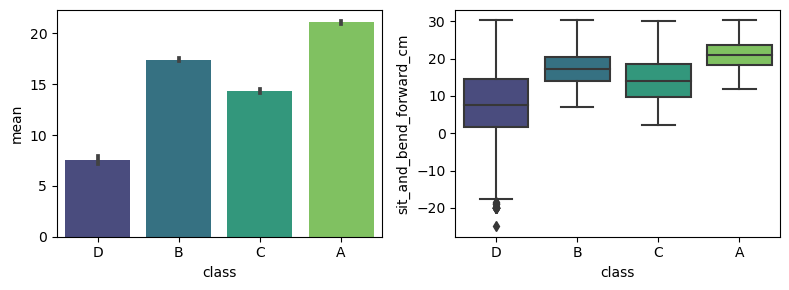

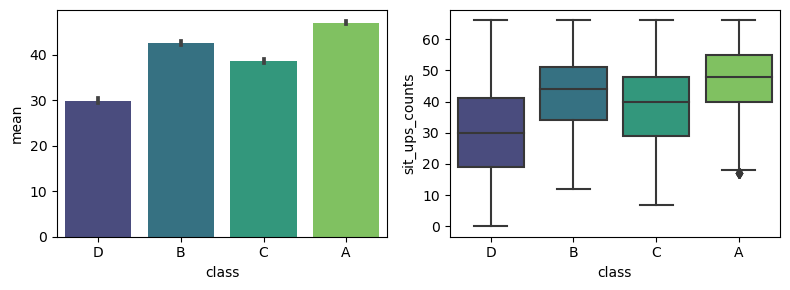

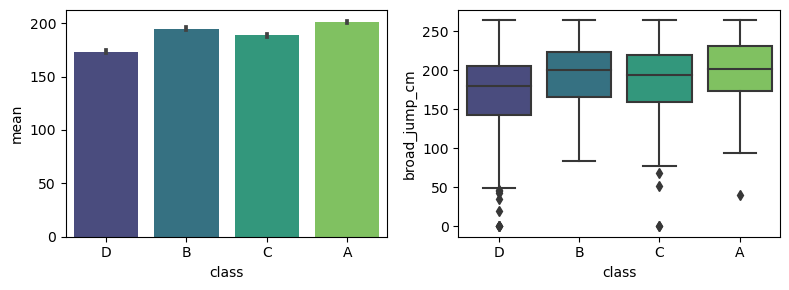

In [14]:
target_feature = 'class'
for col in numerical_features:
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    sns.barplot(
        x=target_feature, 
        y=col, 
        data=df_full_train,
        palette='viridis',
    )
    plt.ylabel('mean')
    plt.subplot(1, 2, 2)
    sns.boxplot(
        x=target_feature,
        y=df_full_train[col],
        data=df_full_train,
        palette='viridis',
    )
    plt.tight_layout() # adjust layout and add some margin between 2 plots
    plt.show()

###### Multivariate analysis

<Axes: >

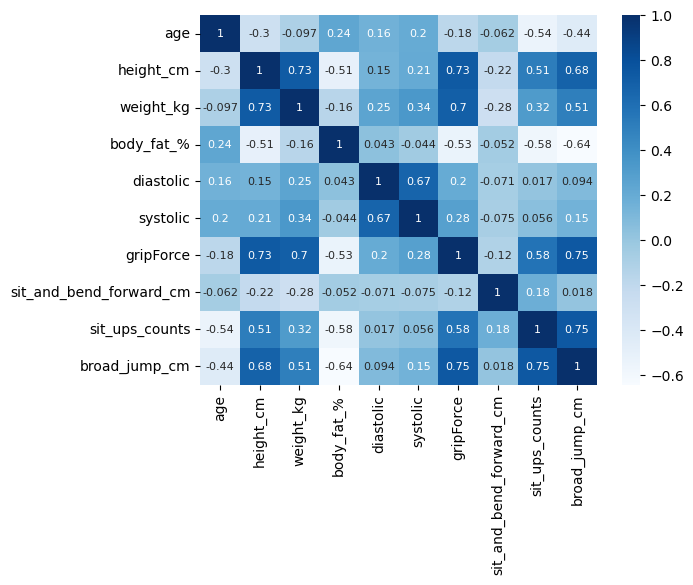

In [15]:
sns.heatmap(df_full_train[numerical_features].corr(), cmap="Blues", annot=True, annot_kws={"fontsize":8})

##### Categorical features

<Axes: xlabel='gender', ylabel='count'>

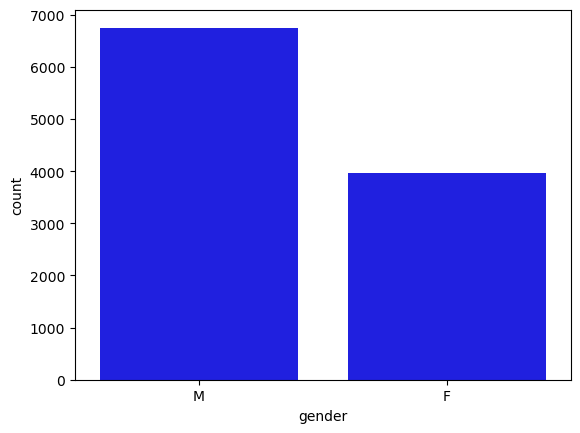

In [16]:
sns.countplot(data = df_full_train, x = 'gender', color = 'blue')

<Axes: xlabel='gender', ylabel='count'>

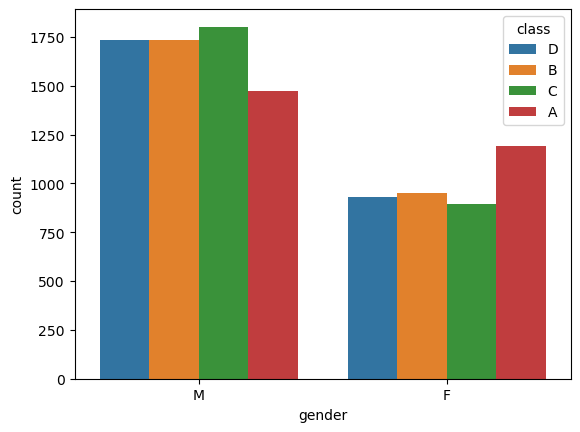

In [17]:
sns.countplot(data = df_full_train, x = 'gender', hue = 'class')

##### Target feature analysis

<Axes: xlabel='class', ylabel='count'>

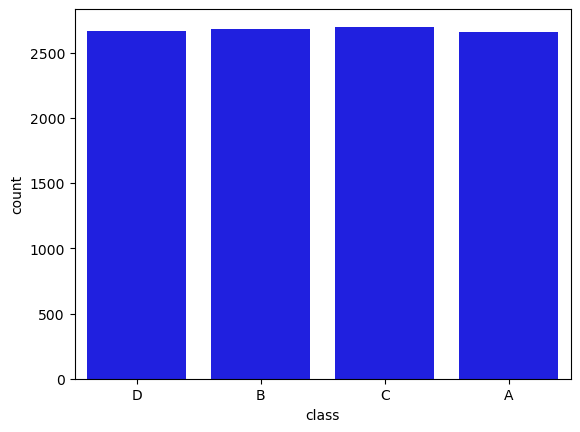

In [18]:
sns.countplot(data = df_full_train, x = 'class', color = 'blue')

### Features importance

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first', handle_unknown='ignore'))
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, make_column_selector(dtype_include=['float64'])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=['object']))
    ])

pipeline = Pipeline([
    ('preprocessor',  preprocessor)
])

In [20]:
from sklearn.feature_selection import mutual_info_classif

X_full_train = df_full_train.drop(columns = ['class'])
y_full_train = df_full_train['class']

pipeline.fit(X_full_train, y_full_train)

X_full_train_transformed = pipeline.named_steps['preprocessor'].transform(X_full_train)
numerical_transformed_columns = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_transformed_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
all_columns = [numerical_transformed_columns + categorical_transformed_columns]
all_columns = all_columns[0]

df_X_full_train_transformed = pd.DataFrame(
    X_full_train_transformed,
    columns = all_columns
)

df_X_full_train_transformed.head()

,age,height_cm,weight_kg,body_fat_%,diastolic,systolic,gripForce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,gender_M
0,-0.722044,0.664130,1.762974,0.155924,1.554519,1.919290,0.309640,0.927441,0.752486,-0.011675,1.0
1,-1.088373,-0.927589,-1.881600,0.055000,0.035234,-0.351336,-1.249508,0.614695,-0.322556,-1.190847,0.0
2,0.889804,-2.239845,-0.483924,2.549281,1.554519,-0.076109,-1.356034,0.514616,-2.257632,-1.062676,0.0
3,-0.062652,1.368860,1.241056,-1.026336,0.130189,0.061505,1.403949,-1.036605,0.465808,0.680448,1.0
4,-0.502247,0.032303,0.227299,-0.161268,1.934340,0.474346,0.677637,0.727283,1.397511,1.346937,1.0


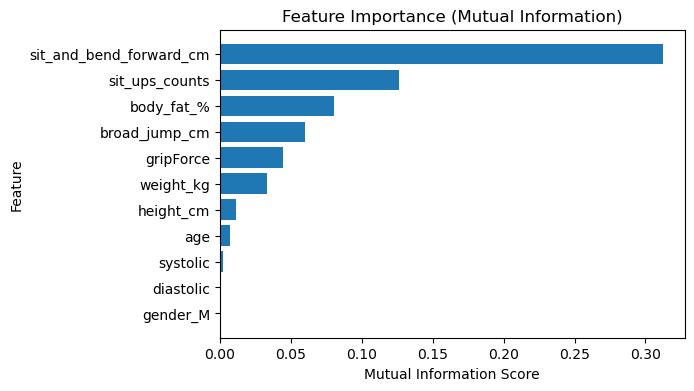

In [21]:
# Compute mutual information
mi_scores = mutual_info_classif(df_X_full_train_transformed, y_full_train, discrete_features=False, random_state=RANDOM_STATE)  
, 
# Create DataFrame for better visualization
mi_df = pd.DataFrame({'feature': df_X_full_train_transformed.columns, 'mi_score': mi_scores})
mi_df = mi_df.sort_values(by="mi_score", ascending=False)

# Plot
plt.figure(figsize=(6, 4))
plt.barh(mi_df['feature'], mi_df['mi_score'])
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Mutual Information)")
plt.gca().invert_yaxis()
plt.show()


In [22]:
mi_df.feature.tolist()

['sit_and_bend_forward_cm',
 'sit_ups_counts',
 'body_fat_%',
 'broad_jump_cm',
 'gripForce',
 'weight_kg',
 'height_cm',
 'age',
 'systolic',
 'diastolic',
 'gender_M']

In [23]:
mi_df.feature

7     sit_and_bend_forward_cm
8              sit_ups_counts
3                  body_fat_%
9               broad_jump_cm
6                   gripForce
2                   weight_kg
1                   height_cm
0                         age
5                    systolic
4                   diastolic
10                   gender_M
Name: feature, dtype: object

### Building baseline model

Many machine learning algorithms can be used to train a multiclass classifier but not all as standard algorithms such as logistic regression, support vector machines (SVM) are designed only for binary classification tasks. 

However, one can use many strategies to leverage these traditional multiclass classification algorithms. 

The algorithms used for multi-class classification can be categorized into the following categories primarily.

- Binary Transformation
- Native Multi-Class Classifier
- Hierarchical Classification

For more details, one can read this article [How to Solve a Multi Class Classification Problem with Python?](https://www.projectpro.io/article/multi-class-classification-python-example/547)

In our case, we focus on Native Multi-Class Classifier methods.

In [24]:
from sklearn.metrics import f1_score, classification_report

In [25]:
labelencoder = LabelEncoder()
# fit and transform
df_full_train['class'] = labelencoder.fit_transform(df_full_train['class'])

In [26]:
df_full_train.head()

,age,gender,height_cm,weight_kg,body_fat_%,diastolic,systolic,gripForce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
0,27.0,M,173.8,87.00,24.1,95.0,158.0,39.9,22.5,50.0,189.0,3
1,22.0,F,160.7,45.80,23.4,79.0,125.0,23.8,20.0,35.0,143.0,1
2,49.0,F,149.9,61.60,40.7,95.0,129.0,22.7,19.2,8.0,148.0,3
3,36.0,M,179.6,81.10,15.9,80.0,131.0,51.2,6.8,46.0,216.0,2
4,30.0,M,168.6,69.64,21.9,99.0,137.0,43.7,20.9,59.0,242.0,0


In [27]:
X_full_train = df_full_train.drop(columns = ['class'])
y_full_train = df_full_train['class']

X_train, X_validation, y_train, y_validation = train_test_split(X_full_train, y_full_train, train_size=.8)

In [28]:
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((8570, 11), (2143, 11), (8570,), (2143,))

In [29]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_validation_transformed = pipeline.named_steps['preprocessor'].transform(X_validation)

In [30]:
rf_scores = []
print('Random forest classifier')
for d in [5, 10, 15, 20, 50, None]:
    for n in [5, 10, 15, 20, 50, 100, 200]:
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n, max_depth = d,)
        rf.fit(X_train_transformed, y_train)
        y_validation_pred = rf.predict(X_validation_transformed)
        score = f1_score(y_validation, y_validation_pred, average='weighted')
        print(f'd = {d}, n = {n} ==> f1 score = {score}')
        rf_scores.append((n, d, score))

print('************************')
print('Decision tree classifier')            
dt_scores = []
for d in [5, 10, 15, 20, 50, None]:
    for l in [1, 3, 5, 10, 15, 20, 30, 50, 100]:
        dt = DecisionTreeClassifier(random_state = RANDOM_STATE, max_depth = d, min_samples_leaf= l, )
        dt.fit(X_train_transformed, y_train)
        y_validation_pred = dt.predict(X_validation_transformed)
        score = f1_score(y_validation, y_validation_pred, average='weighted')
        print(f'd = {d}, l = {l} ==> f1 score = {score}')
        dt_scores.append((l, d, score))

print('************************')
print('XGBoost classifier')
xgb_scores = []
for e in [0.001, 0.01, 0.1,]:
    for n in [5, 10, 15, 20, 50, 100, 200]:
        for d in [1, 5, 10, 20, 50, 100]:
            xgb_model = xgb.XGBClassifier(
                eta = e, 
                max_depth = d,
                min_child_weight = 1,
                objective = 'multi:softmax',
                nthread = 12,
                seed = 1,
                verbosity = 1,
                n_estimators = n
            )
            xgb_model.fit(X_train_transformed, y_train)
            y_validation_pred = xgb_model.predict(X_validation_transformed)
            score = f1_score(y_validation, y_validation_pred, average='weighted')
            print(f'e = {e}, n = {n}, d = {d} ==> f1 score = {score}')
            xgb_scores.append((e, n, d, score))

Random forest classifier
d = 5, n = 5 ==> f1 score = 0.5866083660553957
d = 5, n = 10 ==> f1 score = 0.5890773787303845
d = 5, n = 15 ==> f1 score = 0.5985521323096824
d = 5, n = 20 ==> f1 score = 0.594151674466988
d = 5, n = 50 ==> f1 score = 0.6145148684398201
d = 5, n = 100 ==> f1 score = 0.6087865305477864
d = 5, n = 200 ==> f1 score = 0.6025314788124169
d = 10, n = 5 ==> f1 score = 0.6465616786694814
d = 10, n = 10 ==> f1 score = 0.6612165243424343
d = 10, n = 15 ==> f1 score = 0.672748872692006
d = 10, n = 20 ==> f1 score = 0.6689625733543638
d = 10, n = 50 ==> f1 score = 0.6788024126236845
d = 10, n = 100 ==> f1 score = 0.679147069380348
d = 10, n = 200 ==> f1 score = 0.6756698168166426
d = 15, n = 5 ==> f1 score = 0.6419703693816561
d = 15, n = 10 ==> f1 score = 0.6650075369409586
d = 15, n = 15 ==> f1 score = 0.6758262888623073
d = 15, n = 20 ==> f1 score = 0.6775451511304825
d = 15, n = 50 ==> f1 score = 0.694822500217517
d = 15, n = 100 ==> f1 score = 0.6975104339903107
d = 

In [31]:
df_rf_scores = pd.DataFrame(rf_scores, columns = ['n_estimators', 'max_depth', 'f1_score'])
df_dt_scores = pd.DataFrame(dt_scores, columns = ['max_depth', 'min_samples_leaf', 'f1_score'])
df_xgb_scores = pd.DataFrame(xgb_scores, columns = ['eta', 'n_estimators', 'max_depth', 'f1_score'])

##### Get best parameters for each model

In [32]:
from IPython.display import display

display(df_rf_scores.sort_values(by = ['f1_score'], ascending = (False)).head())
display(df_dt_scores.sort_values(by = ['f1_score'], ascending = (False)).head())
display(df_xgb_scores.sort_values(by = ['f1_score'], ascending = (False)).head())

,n_estimators,max_depth,f1_score
27,200,20.0,0.704673
19,100,15.0,0.697510
20,200,15.0,0.695426
41,200,NaN,0.695254
34,200,50.0,0.695254


,max_depth,min_samples_leaf,f1_score
10,3,10.0,0.654168
23,20,15.0,0.653709
14,20,10.0,0.653150
32,20,20.0,0.652263
41,20,50.0,0.652263


,eta,n_estimators,max_depth,f1_score
119,0.1,100,100,0.729248
117,0.1,100,20,0.729225
123,0.1,200,20,0.729058
124,0.1,200,50,0.727810
122,0.1,200,10,0.727754


In [33]:
dt_max_depth = 10
dt_min_samples_leaf = 15

rf_n_estimators = 100
rf_max_depth = 20

xgb_eta = 0.1
xgb_n_estimators = 50
xgb_max_depth = 10

##### Use Cross validation on each best model

In [34]:
dt_model = DecisionTreeClassifier(random_state = RANDOM_STATE, max_depth = dt_max_depth, min_samples_leaf= dt_min_samples_leaf)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators= rf_n_estimators, max_depth = rf_max_depth, )
xgb_model = xgb.XGBClassifier(
                eta = xgb_eta, 
                max_depth = xgb_max_depth,
                min_child_weight = 1,
                objective = 'multi:softmax',
                nthread = 12,
                random_state = RANDOM_STATE,
                verbosity = 1,
                n_estimators = xgb_n_estimators
            )

In [35]:
scores_cv = []
for train_idx, val_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(X_full_train, y_full_train):

    X_train_ = X_full_train.iloc[train_idx]
    y_train_ = y_full_train.iloc[train_idx]
    
    X_validation_ = X_full_train.iloc[val_idx]
    y_validation_ = y_full_train.iloc[val_idx]
    
    preprocessor_cv = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, make_column_selector(dtype_include=['float64'])),
            ('cat', categorical_transformer, make_column_selector(dtype_include=['object'])),
        ])

    pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor_cv)])
    pipeline_cv.fit(X_train_, y_train_)
    
    X_train_transformed_cv = pipeline_cv.named_steps['preprocessor'].transform(X_train_)
    X_validation_transformed_cv = pipeline_cv.named_steps['preprocessor'].transform(X_validation_)
    dt_model.fit(X_train_transformed_cv, y_train_)
    y_validation_pred = dt_model.predict(X_validation_transformed_cv)
    score = f1_score(y_validation_, y_validation_pred, average='weighted')
    scores_cv.append(('dt_model', score))
    
    rf_model.fit(X_train_transformed_cv, y_train_)
    y_validation_pred = rf_model.predict(X_validation_transformed_cv)
    score = f1_score(y_validation_, y_validation_pred, average='weighted')
    scores_cv.append(('rf_model', score))
    
    xgb_model.fit(X_train_transformed_cv, y_train_)
    y_validation_pred = xgb_model.predict(X_validation_transformed_cv)
    score = f1_score(y_validation_, y_validation_pred, average='weighted')
    scores_cv.append(('xgb_model', score))

df_scores_cv = pd.DataFrame(scores_cv, columns = ['model', 'f1_score'])
df_scores_cv.groupby(['model'], as_index=False).agg({'f1_score' : 'mean',})

,model,f1_score
0,dt_model,0.664544
1,rf_model,0.717344
2,xgb_model,0.730297


##### Choosing baseline model

##### Training baseline model

In [36]:
pipeline_baseline = Pipeline([
    ('preprocessor',  preprocessor),
    ('classifier', xgb_model)     
])


In [37]:
pipeline_baseline.fit(X_full_train, y_full_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002ADB4171510>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector ob...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, nthread=12, num_parallel_tree=None, ...))])

##### Evaluate baseline model

In [42]:
df_test['class'] = labelencoder.fit_transform(df_test['class'])
X_test = df_test.drop(columns = ['class'])
y_test = df_test['class']

In [43]:
y_test_pred = pipeline_baseline.predict(X_test)
f1_score(y_test, y_test_pred, average = "weighted")

0.756198628763796

##### Feature importance for baseline model

In [44]:
# get feature importance for xgboost
xgb_score = pipeline_baseline.named_steps['classifier'].get_booster().get_fscore()
df_xgb_score = pd.DataFrame({'name' : X_full_train.columns.tolist() , 'importance' : [v for v in xgb_score.values()]})
df_xgb_score.sort_values(by = ['importance'], ascending = False).reset_index(drop = True)

,name,importance
0,age,4415.0
1,sit_and_bend_forward_cm,4299.0
2,gripForce,4202.0
3,height_cm,4176.0
4,systolic,3923.0
5,weight_kg,3514.0
6,sit_ups_counts,3107.0
7,gender,2981.0
8,diastolic,2369.0
9,body_fat_%,2259.0


### Improve baseline model

#### Feature engineering for model improvement

In [45]:
df_full_train['bmi'] =  df_full_train['weight_kg'] / (df_full_train['height_cm'] / 100) ** 2
df_full_train['strength_index'] = (df_full_train['gripForce'] + df_full_train['sit_ups_counts']) / df_full_train['weight_kg']
df_full_train['cardio_score'] = (df_full_train['systolic'] + df_full_train['diastolic']) / df_full_train['age']
df_full_train['body_fat_strength_ratio'] = df_full_train['body_fat_%'] / (df_full_train['gripForce'] + df_full_train['sit_ups_counts'])

In [46]:
df_full_train_selected = df_full_train[['gender', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit_and_bend_forward_cm', 'sit_ups_counts',
       'broad_jump_cm', 'age', 'bmi', 'strength_index', 'cardio_score', 'body_fat_strength_ratio', 'class']]

In [47]:
X_full_train_selected = df_full_train_selected.drop(columns = ['class'])
y_full_train_selected = df_full_train_selected['class']

In [48]:
pipeline_model_1 = Pipeline([
    ('preprocessor',  preprocessor),
    ('classifier', xgb_model)     
])

pipeline_model_1.fit(X_full_train_selected, y_full_train_selected)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002ADB4171510>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector ob...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, nthread=12, num_parallel_tree=None, ...))])

In [50]:
X_test['bmi'] =  X_test['weight_kg'] / (X_test['height_cm'] / 100) ** 2
X_test['strength_index'] = (X_test['gripForce'] + X_test['sit_ups_counts']) / X_test['weight_kg']
X_test['cardio_score'] = (X_test['systolic'] + X_test['diastolic']) / X_test['age']
X_test['body_fat_strength_ratio'] = X_test['body_fat_%'] / (X_test['gripForce'] + X_test['sit_ups_counts'])

##### Evaluate model v1

In [51]:
y_test_pred = pipeline_model_1.predict(X_test[['gender', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit_and_bend_forward_cm', 'sit_ups_counts',
       'broad_jump_cm', 'age', 'bmi', 'strength_index', 'cardio_score', 'body_fat_strength_ratio',]])
f1_score(y_test, y_test_pred, average = "weighted")

0.7557333820577016

##### Feature importance for model v1

In [52]:
# get feature importance for xgboost
xgb_score_v1 = pipeline_model_1.named_steps['classifier'].get_booster().get_fscore()
df_xgb_score_v1 = pd.DataFrame({'name' : X_full_train_selected.columns.tolist() , 'importance' : [v for v in xgb_score_v1.values()]})
df_xgb_score_v1.sort_values(by = ['importance'], ascending = False).reset_index(drop = True)

,name,importance
0,gripForce,3715.0
1,sit_and_bend_forward_cm,3275.0
2,bmi,2915.0
3,systolic,2788.0
4,broad_jump_cm,2773.0
5,strength_index,2512.0
6,sit_ups_counts,2434.0
7,age,2432.0
8,weight_kg,2382.0
9,gender,2250.0


#### Use features selection for improving model V1

In [89]:
top_10 = df_xgb_score_v1.sort_values(by = ['importance'], ascending = (False)).head(10)['name'].tolist()
top_10

['gripForce',
 'sit_and_bend_forward_cm',
 'bmi',
 'systolic',
 'broad_jump_cm',
 'strength_index',
 'sit_ups_counts',
 'age',
 'weight_kg',
 'gender']

In [90]:
X_full_train_selected_new = df_full_train_selected[top_10]

In [91]:
pipeline_model_2 = Pipeline([
    ('preprocessor',  preprocessor),
    ('classifier', xgb_model)     
])

pipeline_model_2.fit(X_full_train_selected_new, y_full_train_selected)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002ADB4171510>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector ob...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, nthread=12, num_parallel_tree=None, ...))])

##### Evaluate model v2

In [92]:
y_test_pred = pipeline_model_2.predict(X_test[top_10])
f1_score(y_test, y_test_pred, average = "weighted")

0.73987255815223